# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

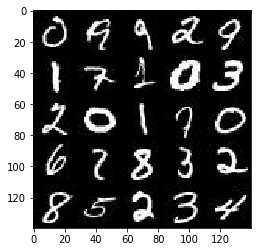

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

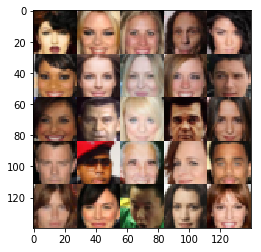

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    l_rate = tf.placeholder(tf.float32)

    return input_real, input_z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xdepth_dim
        
        layer_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # layer_1 is 14x14x64
        
        layer_2 = tf.layers.conv2d(layer_1, 128, 5, strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # layer_2 is 7x7x128
        
        layer_3 = tf.layers.conv2d(layer_2, 256, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # layer_3 is 4x4x256
        
        # Flatten
        flat = tf.reshape(layer_3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Fully connected layer
        layer_1 = tf.layers.dense(z, 4*4*512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        tf.layers.batch_normalization(layer_1, training=is_train)
        # layer_1 is 4x4x512
        
        # How to calculate the size of output map?
        # According to the conv2d valid padding algorithm:
        #   new_size = ceil(input_size - filter_size + 1) / stride
        #   4        = ceil(7          - 4           + 1) / 1
        # So that, if I want the size of output map to be 7, I can choose params like the following:
        #   filter_size=4, stride=1, padding='valid'
        # Of course, there will be some other combination of these params,
        # for more choises, please check: https://discussions.udacity.com/t/generator-output-shape/247548/9
        # Refer to https://github.com/petewarden/tensorflow_makefile/blob/master/tensorflow/core/kernels/ops_util.cc#L37
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 4, strides=1, padding='valid')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # layer_2 is 7x7x256
        
        # The algorithm of output map size for same padding algorithm:
        #   new_size = ceil(input_size / stride)
        #   total_padding_needed = max(0, (new_size - 1) * stride + filter_size - input_size)
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # layer_3 is 14x14x128
        
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, strides=2, padding='same')
        # logits is 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    input_real, input_z, l_rate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                x = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: x, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: x, l_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    gen_samples = sess.run(
                        generator(input_z, data_shape[-1], is_train=False),
                        feed_dict={input_z: sample_z})
                
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 1.5345
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 1.7644
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.8484
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 1.6913
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 1.8776
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.7995
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 0.7811


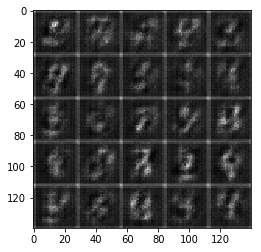

Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 2.0094
Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 1.0150
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.7783
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.7463
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 2.0556
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 1.5110


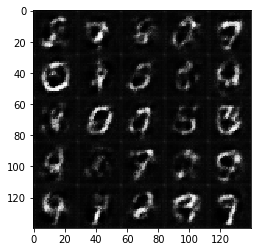

Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.0102
Epoch 1/2... Discriminator Loss: 0.9714... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 2.0934
Epoch 1/2... Discriminator Loss: 0.7734... Generator Loss: 1.2925
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 2.3743
Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.3266
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.2464
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 2.5330
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 0.9386


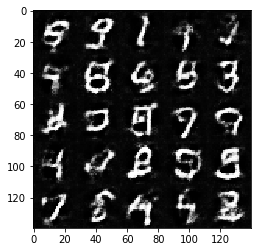

Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.7746
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.6008
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 2.5161
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.3188
Epoch 1/2... Discriminator Loss: 0.8299... Generator Loss: 1.1837
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 0.8654
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 0.9480
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 2.4429


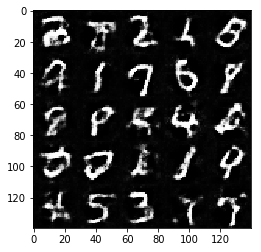

Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 1.5102
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 2.0721
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 1.7984
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.8995
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.3950
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.9655
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.2990


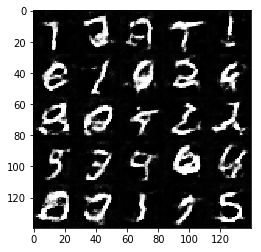

Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.8271
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 2.1313
Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.9791
Epoch 2/2... Discriminator Loss: 0.7847... Generator Loss: 1.3800
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 1.0505
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.3139
Epoch 2/2... Discriminator Loss: 0.8029... Generator Loss: 1.3441


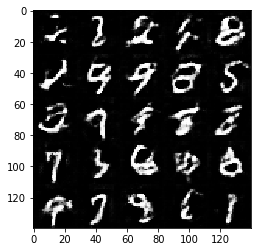

Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 1.4999
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.4454
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 1.7570
Epoch 2/2... Discriminator Loss: 2.8053... Generator Loss: 0.1483
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.5681
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.0019


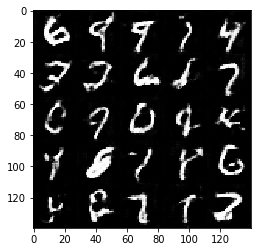

Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.7669
Epoch 2/2... Discriminator Loss: 3.6967... Generator Loss: 5.3156
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 1.3176
Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.3420
Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.8690
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.4829
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.8912
Epoch 2/2... Discriminator Loss: 0.7258... Generator Loss: 1.6954
Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 2.0744


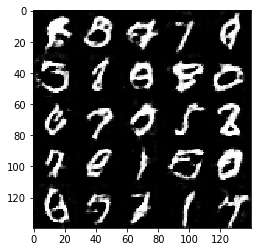

Epoch 2/2... Discriminator Loss: 0.8833... Generator Loss: 1.1417
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.2309
Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.4729
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.5637
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 1.1228
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.0202
Epoch 2/2... Discriminator Loss: 0.9127... Generator Loss: 2.2691


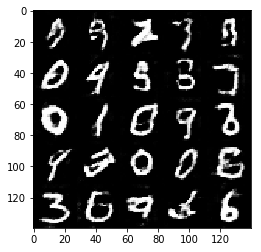

Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.3154


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.8972
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.9668
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 2.8836
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.9972
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.8473


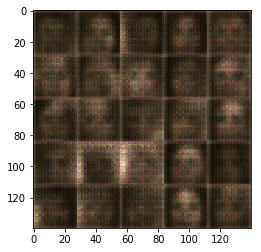

Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.7210
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 2.7768


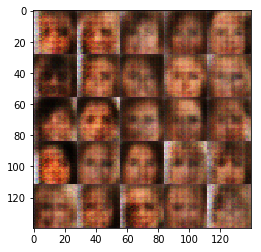

Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.7721
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 2.3836
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.6937


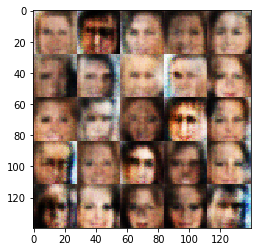

Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.2384


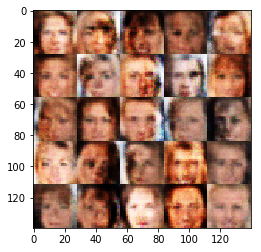

Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.4687
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.6617... Generator Loss: 0.3792
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 2.3224


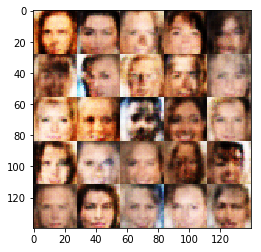

Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.8078
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 2.7293
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.7334
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.6847
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.1196


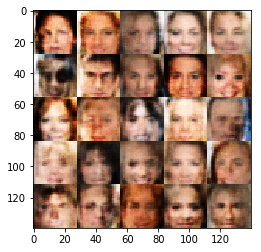

Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 1.9616
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 2.6106
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.8346... Generator Loss: 3.4452
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.2352


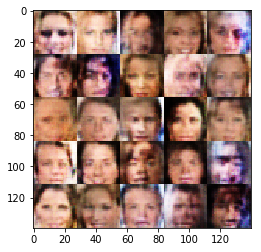

Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 2.3027
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.5382
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.8007
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 2.4809
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.3971


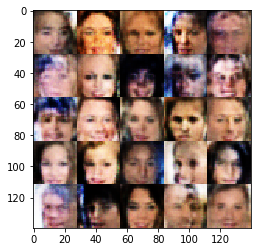

Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 2.1506
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 2.1951
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.7675
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.7660


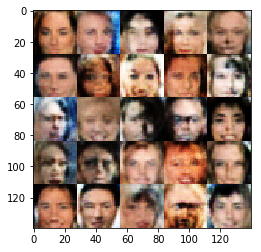

Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 2.0341
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 2.2038
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 2.3083
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.6814
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 1.8185
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.6939


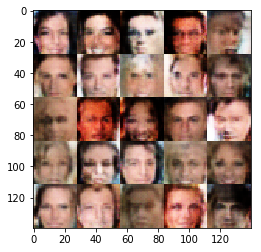

Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.9765
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 2.1506... Generator Loss: 3.0314
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 1.9127
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 2.1834
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 2.2170
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 2.1441
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.5041


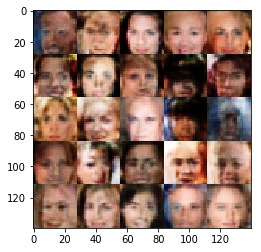

Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.5784
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 2.6850
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 2.0801
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.4702
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 2.1567


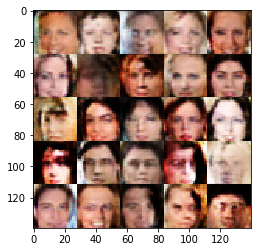

Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 4.1422
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.5787
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 2.1240


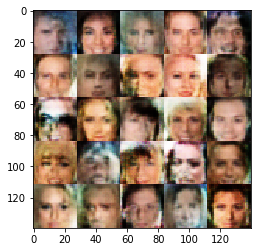

Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 3.1707
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.6658
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.4729
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 3.7446
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.9971


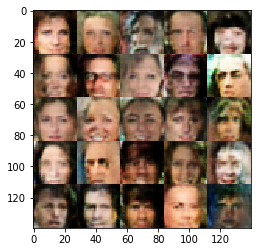

Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 3.5943
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 1.3540
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 3.4571
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 1.9267
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.3613
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.5875
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 2.6260


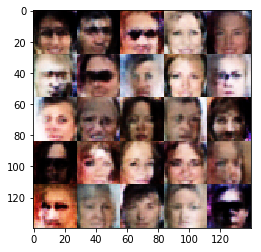

Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.6847
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 2.6394
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.6487
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 2.2754
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.5674


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.